In [234]:
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
import glob
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [235]:
# 측정한 데이터 읽어오기
df = pd.read_csv('./signal.csv')

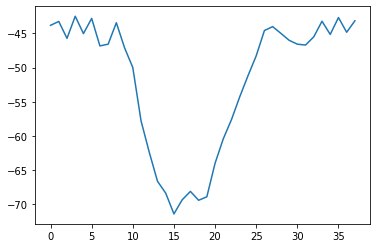

In [236]:
df.loc[:,'Path_loss'].plot();

In [237]:
# 데이터 생성을 위해 noise를 더함
def add_noise(x):
    return x + random.normal(loc=0, scale=2, size=1)[0]

In [238]:
# 랜덤으로 생성된 신호를 모두 이어줌
df_added_noise = pd.DataFrame()
for i in range(34):
    df_added_noise = pd.concat([df_added_noise, df['Path_loss'].apply(add_noise)], axis=0,ignore_index=True)

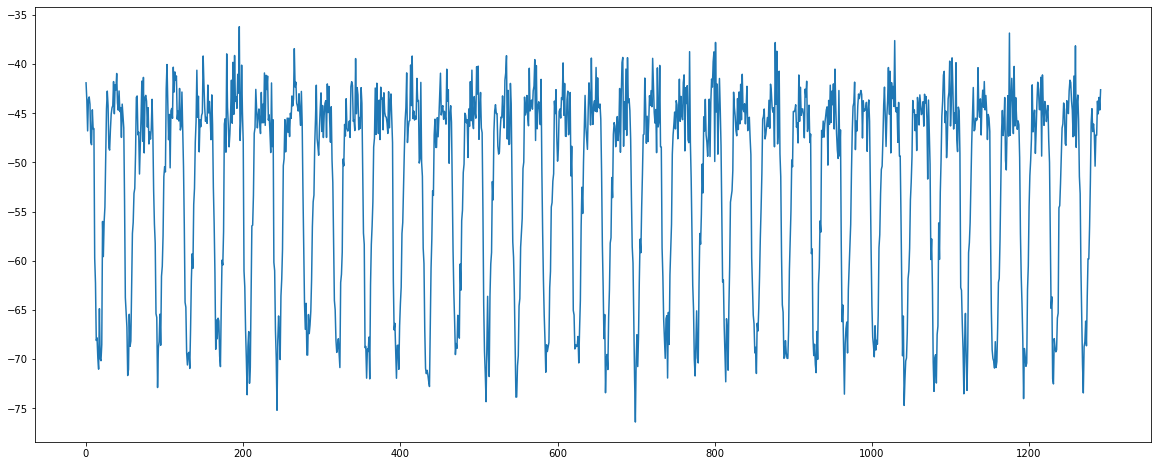

In [239]:
plt.figure(figsize=(20,8))
plt.plot(df_added_noise);

In [240]:
image_list = glob.glob('./path_output_frame2/*')

In [241]:
df_added_noise.loc[:,'Image_path'] = image_list
df_added_noise.columns=['Path_loss','Image_path']

In [242]:
# 상대경로 문자열 수정
def change_str(x):
    return x.replace('\\','/')

In [243]:
df_added_noise['Image_path'] = df_added_noise['Image_path'].apply(change_str)

In [244]:
df_added_noise.iloc[2:4,:]

,Path_loss,Image_path
2,-46.795557,./path_output_frame2/000171.jpg
3,-43.571413,./path_output_frame2/000172.jpg


In [245]:
# 파일 저장
df_added_noise.to_csv('./dff.csv',index=False,header=None);

In [246]:
# pd.read_csv('./dff.csv', header=None)

In [247]:
# 모델 생성
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolution 1   148, 148  3
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        # 636 476 16
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #  72  72  16
        self.cnn2 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
       
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
         
#        36 36 8
        self.cnn3 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
       
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        # 18 18 8
        self.fc1 = nn.Linear(43808, 1)
#         self.fc2 = nn.Linear(2, 1)
#         self.fc3 = nn.Linear(128, 1)
        

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(x)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = self.cnn3(x)
        out = self.relu3(out)
        out = self.maxpool3(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
#         out = self.fc2(out)
        return out

In [248]:
class CustomDatasetFromCsvLocation(Dataset):
    def __init__(self, csv_path):

        self.data_info = pd.read_csv(csv_path, header=None)
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])
        self.label_arr = np.asarray(self.data_info.iloc[:, 0])


        self.data_len = len(self.data_info.index)
#         print(self.data_len)
    def __getitem__(self, index):

        single_image_name = self.image_arr[index]
        img_as_img = Image.open(single_image_name)
#         print(img_as_img)
       
        p = transforms.Compose([
            transforms.Resize([228,228]),
            transforms.CenterCrop(148),
            transforms.ToTensor(),
        ])
     
        # Transform image to tensor
        img_as_tensor = p(img_as_img)

        single_image_label = self.label_arr[index]
#         print(single_image_label)
        return (img_as_tensor, single_image_label.astype(np.float32))

    def __len__(self):
        return self.data_len


In [249]:
custom_mnist_from_csv_loc =  CustomDatasetFromCsvLocation('./dff.csv')

In [250]:
cnn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv_loc,
                                                batch_size=38,
                                                shuffle=False)

In [251]:
model = CNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
training_epochs = 20
# torch.autograd.set_detect_anomaly(True)
loss_list = []

for epoch in range(training_epochs):
    for i, (images, labels) in enumerate(cnn_dataset_loader):

        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(images)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels)

        loss.backward()
        print(f'{epoch} epoch -> {i}-th iteration, loss = {loss}')
        loss_list.append(loss.item())
        
        optimizer.step()
        
    print('-----------------Epoch Finished-----------------')
    

0 epoch -> 0-th iteration, loss = 2794.54736328125
0 epoch -> 1-th iteration, loss = 258100.6875
0 epoch -> 2-th iteration, loss = 2846.10009765625
0 epoch -> 3-th iteration, loss = 2858.7373046875
0 epoch -> 4-th iteration, loss = 2831.68701171875
0 epoch -> 5-th iteration, loss = 2813.665283203125
0 epoch -> 6-th iteration, loss = 2839.182373046875
0 epoch -> 7-th iteration, loss = 2829.65087890625
0 epoch -> 8-th iteration, loss = 2828.08544921875
0 epoch -> 9-th iteration, loss = 2772.076904296875
0 epoch -> 10-th iteration, loss = 2835.1962890625
0 epoch -> 11-th iteration, loss = 2894.692138671875
0 epoch -> 12-th iteration, loss = 2772.427978515625
0 epoch -> 13-th iteration, loss = 2797.251953125
0 epoch -> 14-th iteration, loss = 2727.704833984375
0 epoch -> 15-th iteration, loss = 2714.78662109375
0 epoch -> 16-th iteration, loss = 2771.513916015625
0 epoch -> 17-th iteration, loss = 2706.6533203125
0 epoch -> 18-th iteration, loss = 2729.6396484375
0 epoch -> 19-th iteration

4 epoch -> 18-th iteration, loss = 1629.3056640625
4 epoch -> 19-th iteration, loss = 1600.146728515625
4 epoch -> 20-th iteration, loss = 1613.6832275390625
4 epoch -> 21-th iteration, loss = 1541.7972412109375
4 epoch -> 22-th iteration, loss = 1590.7579345703125
4 epoch -> 23-th iteration, loss = 1607.2864990234375
4 epoch -> 24-th iteration, loss = 1582.3692626953125
4 epoch -> 25-th iteration, loss = 1572.30419921875
4 epoch -> 26-th iteration, loss = 1572.9659423828125
4 epoch -> 27-th iteration, loss = 1577.0264892578125
4 epoch -> 28-th iteration, loss = 1552.9791259765625
4 epoch -> 29-th iteration, loss = 1589.636474609375
4 epoch -> 30-th iteration, loss = 1608.442138671875
4 epoch -> 31-th iteration, loss = 1520.02783203125
4 epoch -> 32-th iteration, loss = 1562.6566162109375
4 epoch -> 33-th iteration, loss = 1534.469482421875
-----------------Epoch Finished-----------------
5 epoch -> 0-th iteration, loss = 1544.2022705078125
5 epoch -> 1-th iteration, loss = 1488.417602

9 epoch -> 0-th iteration, loss = 941.196533203125
9 epoch -> 1-th iteration, loss = 897.6229248046875
9 epoch -> 2-th iteration, loss = 889.8121948242188
9 epoch -> 3-th iteration, loss = 905.151123046875
9 epoch -> 4-th iteration, loss = 891.3916625976562
9 epoch -> 5-th iteration, loss = 892.319091796875
9 epoch -> 6-th iteration, loss = 903.218017578125
9 epoch -> 7-th iteration, loss = 893.9734497070312
9 epoch -> 8-th iteration, loss = 898.5819091796875
9 epoch -> 9-th iteration, loss = 874.9342041015625
9 epoch -> 10-th iteration, loss = 913.6385498046875
9 epoch -> 11-th iteration, loss = 949.6273803710938
9 epoch -> 12-th iteration, loss = 876.3410034179688
9 epoch -> 13-th iteration, loss = 900.5997314453125
9 epoch -> 14-th iteration, loss = 866.2686157226562
9 epoch -> 15-th iteration, loss = 858.1506958007812
9 epoch -> 16-th iteration, loss = 890.792236328125
9 epoch -> 17-th iteration, loss = 860.4888305664062
9 epoch -> 18-th iteration, loss = 878.5154418945312
9 epoch 

13 epoch -> 15-th iteration, loss = 535.5880737304688
13 epoch -> 16-th iteration, loss = 560.6344604492188
13 epoch -> 17-th iteration, loss = 539.27587890625
13 epoch -> 18-th iteration, loss = 555.1071166992188
13 epoch -> 19-th iteration, loss = 534.4937744140625
13 epoch -> 20-th iteration, loss = 543.60595703125
13 epoch -> 21-th iteration, loss = 508.8120422363281
13 epoch -> 22-th iteration, loss = 531.8074340820312
13 epoch -> 23-th iteration, loss = 549.534912109375
13 epoch -> 24-th iteration, loss = 532.9563598632812
13 epoch -> 25-th iteration, loss = 530.6357421875
13 epoch -> 26-th iteration, loss = 530.6508178710938
13 epoch -> 27-th iteration, loss = 538.8079833984375
13 epoch -> 28-th iteration, loss = 527.11083984375
13 epoch -> 29-th iteration, loss = 550.4880981445312
13 epoch -> 30-th iteration, loss = 563.1691284179688
13 epoch -> 31-th iteration, loss = 512.3529052734375
13 epoch -> 32-th iteration, loss = 537.1201782226562
13 epoch -> 33-th iteration, loss = 52

17 epoch -> 28-th iteration, loss = 348.5080261230469
17 epoch -> 29-th iteration, loss = 367.69805908203125
17 epoch -> 30-th iteration, loss = 378.21148681640625
17 epoch -> 31-th iteration, loss = 337.5588684082031
17 epoch -> 32-th iteration, loss = 356.8521423339844
17 epoch -> 33-th iteration, loss = 342.4413757324219
-----------------Epoch Finished-----------------
18 epoch -> 0-th iteration, loss = 350.413330078125
18 epoch -> 1-th iteration, loss = 323.54736328125
18 epoch -> 2-th iteration, loss = 319.0521240234375
18 epoch -> 3-th iteration, loss = 333.899658203125
18 epoch -> 4-th iteration, loss = 325.39495849609375
18 epoch -> 5-th iteration, loss = 334.6512756347656
18 epoch -> 6-th iteration, loss = 335.6957702636719
18 epoch -> 7-th iteration, loss = 324.68212890625
18 epoch -> 8-th iteration, loss = 330.7195129394531
18 epoch -> 9-th iteration, loss = 322.699951171875
18 epoch -> 10-th iteration, loss = 346.2713317871094
18 epoch -> 11-th iteration, loss = 367.6268615

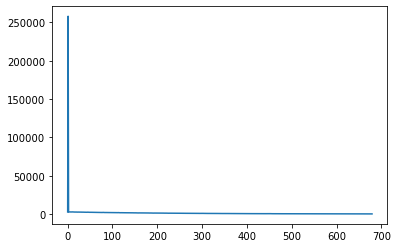

In [252]:
plt.plot(loss_list);

In [253]:
df_new = pd.DataFrame()
df_new = pd.concat([df_new, df['Path_loss']], axis=0,ignore_index=True)

In [254]:
# test 이미지
image_list = glob.glob('./path_output_frame1/*')
df_new.loc[:,'Image_path'] = image_list
df_new.columns=['Path_loss','Image_path']

In [255]:
df_new['Image_path'] = df_new['Image_path'].apply(change_str)
df_new.to_csv('./df_new.csv',index=False,header=None);

In [256]:
custom_mnist_from_csv_loc_test =  CustomDatasetFromCsvLocation('./df_new.csv')

In [257]:
CNN_dataset_loader_test = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv_loc_test,
                                                batch_size=1,
                                                shuffle=False)

In [258]:
result_list = []

with torch.no_grad():
    for i, (images, labels) in enumerate(CNN_dataset_loader_test):
        #     print(i,end='\n\n')
            images = Variable(images)
            labels = Variable(labels)

            outputs = model(images)
            outputs = outputs.squeeze(1)
            result_list.append(outputs[0])

            print(outputs)
            loss = criterion(outputs, labels)
            print(f'{i}-th iteration, loss = {loss}')

            optimizer.step()
    
# loss 저장
df_list = pd.DataFrame(result_list)

tensor([-38.3274])
0-th iteration, loss = 30.091718673706055
tensor([-38.3549])
1-th iteration, loss = 23.893518447875977
tensor([-38.3824])
2-th iteration, loss = 53.752471923828125
tensor([-38.4099])
3-th iteration, loss = 16.59027671813965
tensor([-38.4374])
4-th iteration, loss = 43.291404724121094
tensor([-38.4649])
5-th iteration, loss = 18.7933406829834
tensor([-38.4924])
6-th iteration, loss = 69.39954376220703
tensor([-38.5199])
7-th iteration, loss = 64.80482482910156
tensor([-38.5473])
8-th iteration, loss = 23.86958122253418
tensor([-38.5748])
9-th iteration, loss = 72.8148422241211
tensor([-38.6023])
10-th iteration, loss = 129.70176696777344
tensor([-38.6298])
11-th iteration, loss = 366.8824157714844
tensor([-38.6573])
12-th iteration, loss = 562.6232299804688
tensor([-38.6848])
13-th iteration, loss = 780.4866333007812
tensor([-38.7123])
14-th iteration, loss = 879.2822875976562
tensor([-38.7398])
15-th iteration, loss = 1067.080810546875
tensor([-38.7673])
16-th iterat

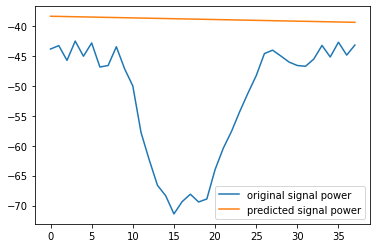

In [259]:
plt.plot(df_new['Path_loss'], label='original signal power')
plt.plot(df_list, label='predicted signal power')
plt.legend();